In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from tianshou.data import Batch

In [4]:
from argo.models.protagonist import DQNPolicy
from argo.datasets.sepsis import get_patient_dataset, get_judge_dataset
from argo.library.evaluation import wis_clinician, jstf, full_vs_partial_context, get_action_counts

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [5]:
_ = sns.set_style("darkgrid")
_ = torch.manual_seed(5568)
_ = np.random.seed(5568)

In [6]:
discount = 0.99
action_dim = 25
device = torch.device("cuda:0")
seeds = [202302, 667495, 114159, 965751, 448102]
train_dict = torch.load("./assets/data/sepsis/train_dict.pt", map_location=device)
val_dict = torch.load("./assets/data/sepsis/val_dict.pt", map_location=device)
test_dict = torch.load("./assets/data/sepsis/test_dict.pt", map_location=device)
clinician = torch.load("./assets/models/clinician/clinician.pt", map_location=device)["model"]
results_dir = Path("./results/")

## Evaluation of Sepsis Treatment Policy

This section evaluates the effectivness of policies in treating sepsis.

In [18]:
# Judge models (6 and 4 arguments versions)
judge = torch.load("./assets/models/judge/judge.pt", map_location=device).eval()
judge_4arg = torch.load("./assets/models/judge/judge.4.pt", map_location=device).eval()

# Argumentator model (6 arguments version)
argumentator = torch.load("./assets/models/argumentator/6/argumentator.debate-minimax.pt", map_location=device)["model"].eval()
argumentator._deterministic_eval = True

# Argumentator model (4 arguments version)
argumentator_4arg = torch.load("./assets/models/argumentator/4/argumentator.debate-minimax.pt", map_location=device)["model"].eval()
argumentator_4arg._deterministic_eval = True

Results of task policy training using 6-arguments debate (apart from l00, which is the *baseline*).

In [17]:
protagonist_l00_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l00/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l25_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l25/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l50_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l50/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l75_jstf  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l75/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l100_jstf = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/6/l100/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]

Results of task policy training using 4-arguments debate (apart from l00, which is the *baseline*, same as in 6-arguments case, copied here for convenience).

In [16]:
protagonist_l00_jstf_4arg  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/4/l00/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l25_jstf_4arg  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/4/l25/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l50_jstf_4arg  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/4/l50/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l75_jstf_4arg  = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/4/l75/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l100_jstf_4arg = [torch.load(f"./assets/models/protagonist/ddqn/justifiable/4/l100/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]

Results of task policy training using judge with access to the full state (apart from l00, which is the *baseline*, same as in 6-arguments case, copied here for convenience).

In [15]:
protagonist_l00_full_state  = [torch.load(f"./assets/models/protagonist/ddqn/full_state/l00/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l25_full_state  = [torch.load(f"./assets/models/protagonist/ddqn/full_state/l25/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l50_full_state  = [torch.load(f"./assets/models/protagonist/ddqn/full_state/l50/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l75_full_state  = [torch.load(f"./assets/models/protagonist/ddqn/full_state/l75/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]
protagonist_l100_full_state = [torch.load(f"./assets/models/protagonist/ddqn/full_state/l100/protagonist-s{s}.pt", map_location=device)["model"].eval() for s in seeds]

### Qualitative Analysis

In this section, we perform different analysis pertaining to patient mortality, justifiability and overall policy quality.

#### Dose Excess for Different Justifiability Levels

To start with, we first show the dose excess for each of the values of lambda in a single plot for intravenous fluids (IV) and vasopressors (VC).

In [11]:
data_raw = pd.read_csv("./assets/data/sepsis/sepsis_final_data_raw.csv")

In [12]:
data_filtered = data_raw[(data_raw["r:reward"] != 0) & (data_raw["o:SOFA"] >= 0) & (data_raw["o:SOFA"] <= 15)]
data_ids = data_filtered["traj"].tolist()

In [13]:
_, dataloader, _ = get_patient_dataset(data_dict=test_dict, filter_ids=data_ids, batch_size=128, use_dem=True, mask=False, num_workers=0)
iv_median = torch.tensor([0.0, 30.0, 85.0, 320.0, 946.0]).repeat_interleave(5).to(device)
vc_median = torch.tensor([0.0, 0.04, 0.13, 0.27, 0.68]).repeat(5).to(device)

In [17]:
def get_excess_mortality(protagonist: DQNPolicy, label: str, seed: int, medication: str = "iv", bins: int = 7):
    excess_count = torch.empty((0, ), dtype=torch.float32, device=device)
    excess_mortality = torch.empty((0, ), dtype=torch.float32, device=device)

    for s, a_true, r, _, _ in dataloader:
        s, r = s.to(device), r.to(device)
        a_true = a_true.argmax(dim=-1).float().to(device)
        a_prot = torch.tensor(protagonist(Batch(obs=s.flatten(end_dim=1), info={})).act.reshape(a_true.shape), device=device).float()

        mask = (r == 0)
        s, r, a_true, a_prot = s[~mask], r[~mask], a_true[~mask], a_prot[~mask]

        # calculate dose excess of clinician from the AI policy 
        doses = iv_median if medication == "iv" else vc_median
        for a in range(action_dim): a_true[a_true == a], a_prot[a_prot == a] = doses[a], doses[a]
        excess = (a_true - a_prot)
        excess_count = torch.cat((excess_count, excess))

        # calculate observed mortality
        mortality = (r == -1.0).int()
        excess_mortality = torch.cat((excess_mortality, mortality))

    df = pd.DataFrame(torch.cat((excess_count[:, None], excess_mortality[:, None]), dim=-1).cpu().numpy(), columns=["excess", "mortality"])
    df["excess"] = pd.cut(df["excess"], bins=bins, include_lowest=True, precision=2)
    df["excess"] = df["excess"].map(lambda x: x.mid)
    df["label"], df["seed"] = label, seed
    return df

In [18]:
# IV (6-arguments case)
mortality_vc_l00 = [get_excess_mortality(protagonist=protagonist_l00_jstf[i], medication="vc", bins=5, label="λ=0.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l25 = [get_excess_mortality(protagonist=protagonist_l25_jstf[i], medication="vc", bins=5, label="λ=0.25", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l50 = [get_excess_mortality(protagonist=protagonist_l50_jstf[i], medication="vc", bins=5, label="λ=0.50", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l75 = [get_excess_mortality(protagonist=protagonist_l75_jstf[i], medication="vc", bins=5, label="λ=0.75", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l100 = [get_excess_mortality(protagonist=protagonist_l100_jstf[i], medication="vc", bins=5, label="λ=1.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc = pd.concat(mortality_vc_l00 + mortality_vc_l25 + mortality_vc_l50 + mortality_vc_l75 + mortality_vc_l100)
mortality_vc.to_csv(results_dir / "protagonist_mortality_vc.csv", index=False)

# VC (6-arguments case)
mortality_iv_l00 = [get_excess_mortality(protagonist=protagonist_l00_jstf[i], medication="iv", bins=7, label="λ=0.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l25 = [get_excess_mortality(protagonist=protagonist_l25_jstf[i], medication="iv", bins=7, label="λ=0.25", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l50 = [get_excess_mortality(protagonist=protagonist_l50_jstf[i], medication="iv", bins=7, label="λ=0.50", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l75 = [get_excess_mortality(protagonist=protagonist_l75_jstf[i], medication="iv", bins=7, label="λ=0.75", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l100 = [get_excess_mortality(protagonist=protagonist_l100_jstf[i], medication="iv", bins=7, label="λ=1.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv = pd.concat(mortality_iv_l00 + mortality_iv_l25 + mortality_iv_l50 + mortality_iv_l75 + mortality_iv_l100)
mortality_iv.to_csv(results_dir / "protagonist_mortality_iv.csv", index=False)

In [16]:
# IV (4-arguments case)
mortality_vc_l00_4arg = [get_excess_mortality(protagonist=protagonist_l00_jstf_4arg[i], medication="vc", bins=5, label="λ=0.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l25_4arg = [get_excess_mortality(protagonist=protagonist_l25_jstf_4arg[i], medication="vc", bins=5, label="λ=0.25", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l50_4arg = [get_excess_mortality(protagonist=protagonist_l50_jstf_4arg[i], medication="vc", bins=5, label="λ=0.50", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l75_4arg = [get_excess_mortality(protagonist=protagonist_l75_jstf_4arg[i], medication="vc", bins=5, label="λ=0.75", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_l100_4arg = [get_excess_mortality(protagonist=protagonist_l100_jstf_4arg[i], medication="vc", bins=5, label="λ=1.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_vc_4arg = pd.concat(mortality_vc_l00_4arg + mortality_vc_l25_4arg + mortality_vc_l50_4arg + mortality_vc_l75_4arg + mortality_vc_l100_4arg)
mortality_vc_4arg.to_csv(results_dir / "protagonist_mortality_vc_4arg.csv", index=False)

# VC (4-arguments case)
mortality_iv_l00_4arg = [get_excess_mortality(protagonist=protagonist_l00_jstf_4arg[i], medication="iv", bins=7, label="λ=0.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l25_4arg = [get_excess_mortality(protagonist=protagonist_l25_jstf_4arg[i], medication="iv", bins=7, label="λ=0.25", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l50_4arg = [get_excess_mortality(protagonist=protagonist_l50_jstf_4arg[i], medication="iv", bins=7, label="λ=0.50", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l75_4arg = [get_excess_mortality(protagonist=protagonist_l75_jstf_4arg[i], medication="iv", bins=7, label="λ=0.75", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_l100_4arg = [get_excess_mortality(protagonist=protagonist_l100_jstf_4arg[i], medication="iv", bins=7, label="λ=1.0", seed=seed) for i, seed in enumerate(seeds)]
mortality_iv_4arg = pd.concat(mortality_iv_l00_4arg + mortality_iv_l25_4arg + mortality_iv_l50_4arg + mortality_iv_l75_4arg + mortality_iv_l100_4arg)
mortality_iv_4arg.to_csv(results_dir / "protagonist_mortality_iv_4arg.csv", index=False)

### Action Distribution

To better understand the peculiarities of learned policies, we plot their action distribution.

In [28]:
data_raw = pd.read_csv("./assets/data/sepsis/sepsis_final_data_raw.csv")

In [29]:
_, dataloader, _ = get_patient_dataset(data_dict=test_dict, batch_size=128, use_dem=True, mask=True, shuffle=False, num_workers=0)

In [31]:
data_filtered = data_raw[(data_raw["r:reward"] != 0) & (data_raw["o:SOFA"] >= 5) & (data_raw["o:SOFA"] <= 15)]
ids = data_filtered["traj"].tolist()
_, dataloader, _ = get_patient_dataset(data_dict=test_dict, filter_ids=ids, batch_size=256, use_dem=True, mask=True, num_workers=0, device=device)

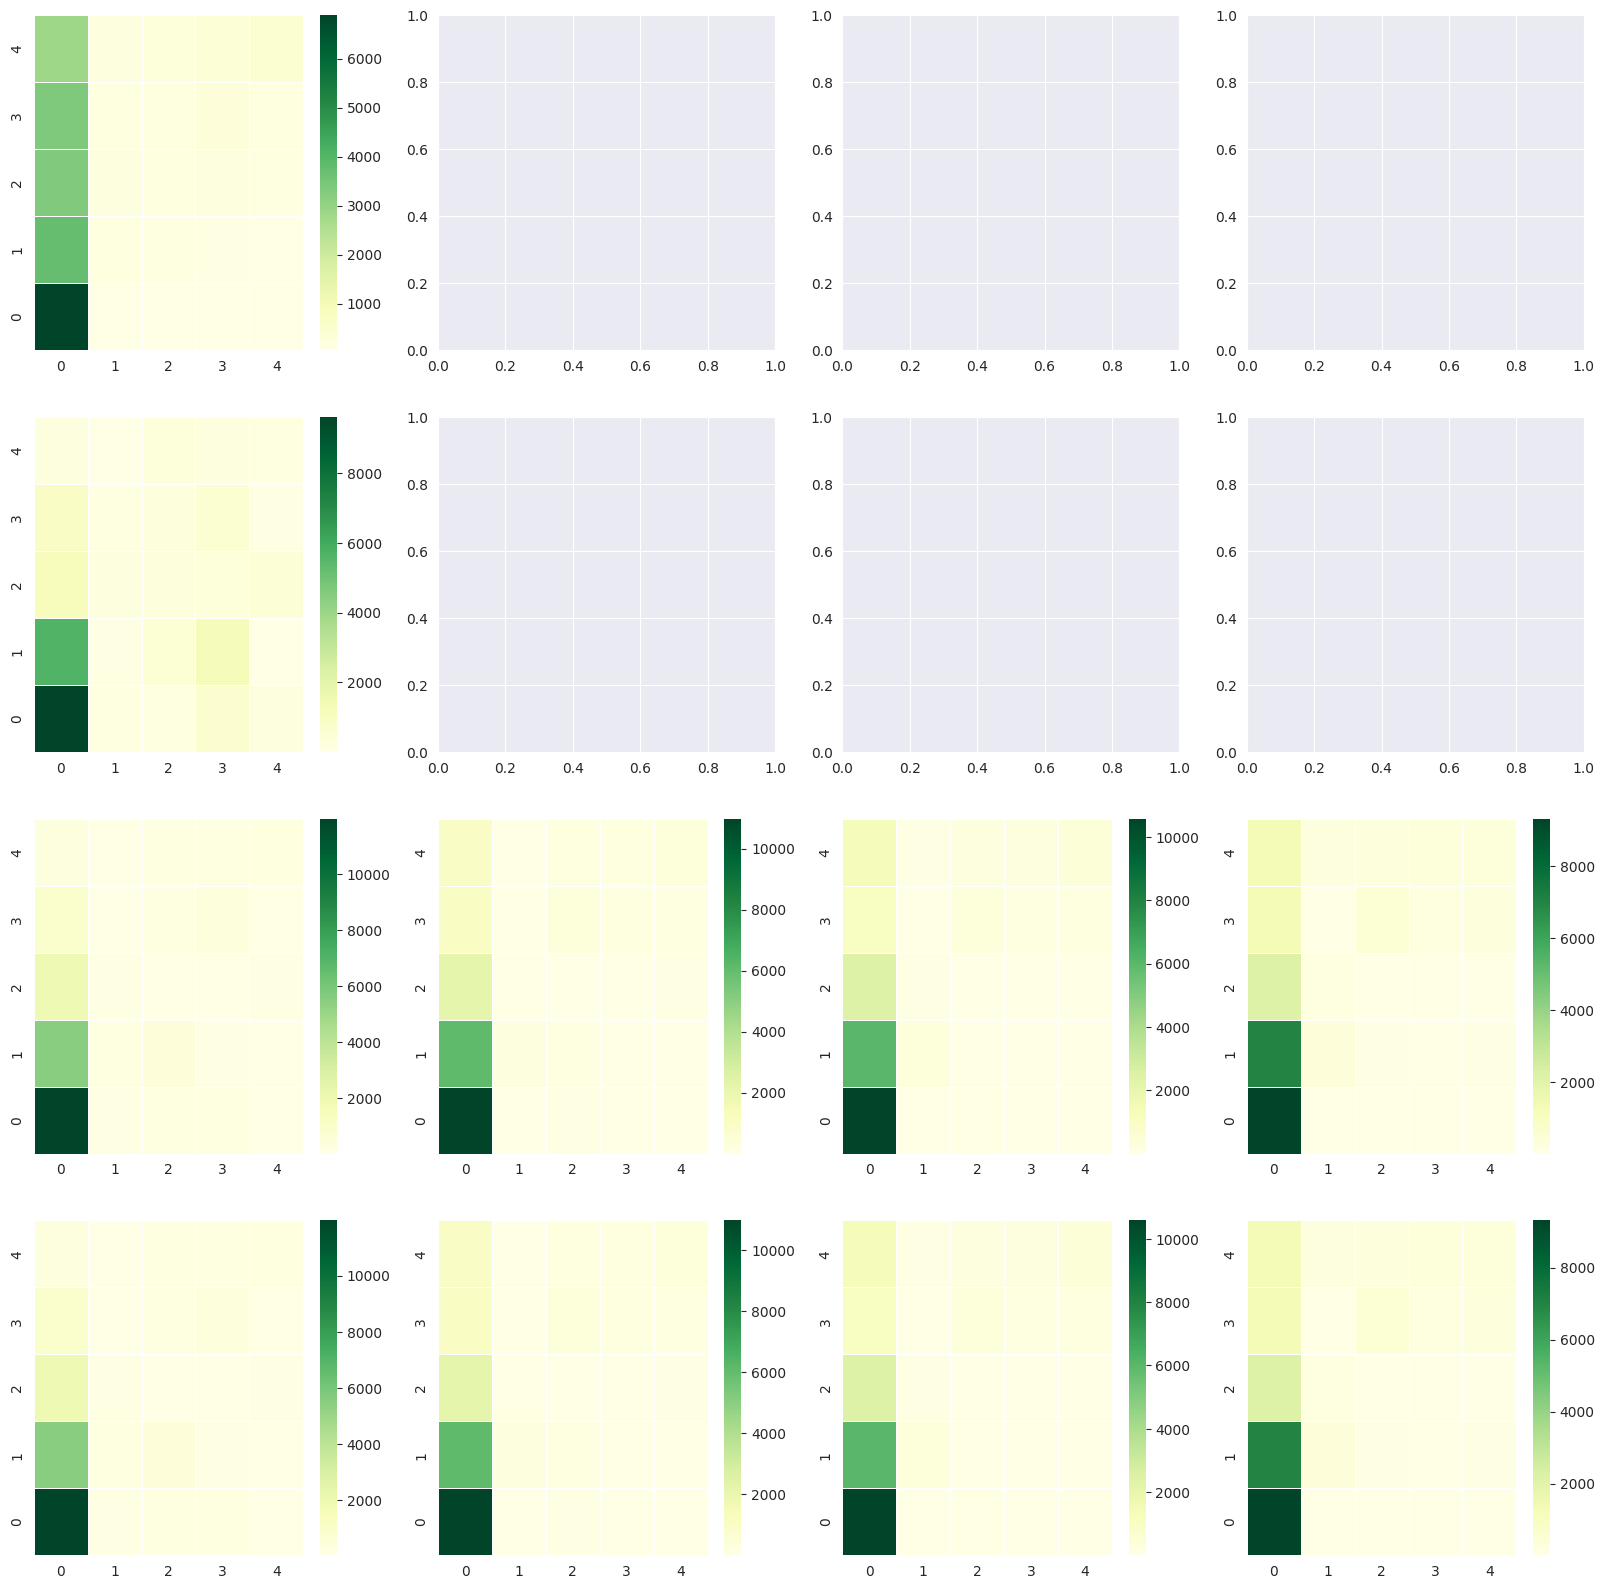

In [20]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))

# plots clinician's distribution (first row)
counts = get_action_counts(dataloader, None, device=device)
_ = sns.heatmap(data=counts.reshape((5, 5)), annot=False, linewidth=0.5, fmt="d", cmap="YlGn", ax=ax[0, 0])
_ = ax[0, 0].invert_yaxis()

# plots baseline policy (second row)
counts = get_action_counts(dataloader, protagonist_l00_jstf, device=device)
_ = sns.heatmap(data=counts.reshape((5, 5)), annot=False, linewidth=0.5, fmt="d", cmap="YlGn", ax=ax[1, 0])
_ = ax[1, 0].invert_yaxis()

# plots justifiable (partial-context) policies (third row)
for act_ind, policy in enumerate([protagonist_l25_jstf, protagonist_l50_jstf, protagonist_l75_jstf, protagonist_l100_jstf]):
    counts = get_action_counts(dataloader, policy, device=device)
    _ = sns.heatmap(data=counts.reshape((5, 5)), annot=False, linewidth=0.5, fmt="d", cmap="YlGn", ax=ax[2, act_ind])
    _ = ax[2, act_ind].invert_yaxis()

# plots aligned (full-context) policies (fourth row)
for act_ind, policy in enumerate([protagonist_l25_jstf, protagonist_l50_jstf, protagonist_l75_jstf, protagonist_l100_jstf]):
    counts = get_action_counts(dataloader, policy, device=device)
    _ = sns.heatmap(data=counts.reshape((5, 5)), annot=False, linewidth=0.5, fmt="d", cmap="YlGn", ax=ax[3, act_ind])
    _ = ax[3, act_ind].invert_yaxis()

### Full vs Partial Context

In this section we showcase the judge's preference over policies trained with full-state vs. partial (6 arguments) judge. 

In [60]:
_, dataloader, _ = get_judge_dataset(data_dict=None, load_path="./assets/data/sepsis/test_preferences.pt", batch_size=256, num_workers=0)

Evaluate the 6-arg case.

In [61]:
data = pd.DataFrame(
    [{"label": "λ=0.25", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l25_jstf[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.25", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l25_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.50", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l50_jstf[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.50", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l50_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.75", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l75_jstf[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.75", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l75_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=1.0", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l100_jstf[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=1.0", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l100_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)])
data.to_csv(results_dir / "protagonist_full_vs_partial_context.csv", index=False)

100%|██████████| 145/145 [00:02<00:00, 67.36it/s]


Evaluate the 4-arg case.

In [62]:
data = pd.DataFrame(
    [{"label": "λ=0.25", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l25_jstf_4arg[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.25", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l25_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.50", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l50_jstf_4arg[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.50", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l50_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.75", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l75_jstf_4arg[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=0.75", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l75_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=1.0", "kind": "partial context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l100_jstf_4arg[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)] +
    [{"label": "λ=1.0", "kind": "full context", "seed": seed, "preference": full_vs_partial_context(policy=protagonist_l100_full_state[i], dataloader=dataloader, device=device)} for i, seed in enumerate(seeds)])
data.to_csv(results_dir / "protagonist_full_vs_partial_context_4arg.csv", index=False)

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:01<00:00, 77.27it/s]


## Qualitative Evaluation

In this section, we review agents trained with different levels of $\lambda$ parameter, showcasing their target performance in terms of WIS evaluation as well as the level of justifiability compared to the baseline policy trained with $\lambda=0.0$.

### Justifiability Comparison

In this section, we calculate the judge's preference over the baseline policy.

Evaluate the 6-arg case.

In [20]:
_, dataloader, _ = get_patient_dataset(data_dict=test_dict, batch_size=256, use_dem=True, mask=True, shuffle=False, num_workers=0)

In [17]:
data = []
for act_ind in range(len(seeds)):
    data += [
        {"label": "λ=0.25", "justifiability": jstf(justifiable=protagonist_l25_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device)},
        {"label": "λ=0.50", "justifiability": jstf(justifiable=protagonist_l50_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device)},
        {"label": "λ=0.75", "justifiability": jstf(justifiable=protagonist_l75_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device)},
        {"label": "λ=1.0", "justifiability": jstf(justifiable=protagonist_l100_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device)},
    ]
data = pd.DataFrame(data).round(decimals=2)
data.to_csv(results_dir / "protagonist_jstf_vs_baseline_per.csv", index=False)

In [27]:
data = []
for act_ind in range(len(seeds)):
    data = []
    data += [{"label": "λ=0.25", "justifiability": j} for j in jstf(justifiable=protagonist_l25_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
    data += [{"label": "λ=0.50", "justifiability": j} for j in jstf(justifiable=protagonist_l50_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
    data += [{"label": "λ=0.75", "justifiability": j} for j in jstf(justifiable=protagonist_l75_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
    data += [{"label": "λ=1.0", "justifiability": j} for j in jstf(justifiable=protagonist_l100_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
data = pd.DataFrame(data).round(decimals=2)
data.to_csv(results_dir / "protagonist_jstf_vs_baseline_dist.csv", index=False)

We also record discrepancy between actions proposed by the justifiable and baseline agent.

In [ ]:
def eval_equivalent(justifiable, baseline, dataloader, device="cuda"):
    result = torch.empty((0, ), dtype=torch.int, device=device)

    for s_t, _, _, _, _ in dataloader:
        s_t = s_t.to(device)
        a_justifiable = torch.tensor(justifiable(Batch(obs=s_t, info={})).act, device=device)
        a_baseline = torch.tensor(baseline(Batch(obs=s_t, info={})).act, device=device)
        result = torch.cat((result, (a_justifiable == a_baseline).int()))

    return result.tolist()

In [ ]:
data = []
for act_ind in range(len(seeds)):
    data = []
    data += [{"label": "λ=0.25", "equal": j} for j in eval_equivalent(justifiable=protagonist_l25_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
    data += [{"label": "λ=0.50", "equal": j} for j in eval_equivalent(justifiable=protagonist_l50_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
    data += [{"label": "λ=0.75", "equal": j} for j in eval_equivalent(justifiable=protagonist_l75_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
    data += [{"label": "λ=1.0", "equal": j} for j in eval_equivalent(justifiable=protagonist_l100_jstf[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
data = pd.DataFrame(data).round(decimals=2)
data.to_csv(results_dir / "protagonist_jstf_vs_baseline_eq.csv", index=False)

Evaluate the 4-arg case by repeating all previous evaluations.

In [18]:
data = []
for act_ind in range(len(seeds)):
    data += [
        {"label": "λ=0.25", "justifiability": jstf(justifiable=protagonist_l25_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator_4arg, judge=judge_4arg, device=device)},
        {"label": "λ=0.50", "justifiability": jstf(justifiable=protagonist_l50_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator_4arg, judge=judge_4arg, device=device)},
        {"label": "λ=0.75", "justifiability": jstf(justifiable=protagonist_l75_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator_4arg, judge=judge_4arg, device=device)},
        {"label": "λ=1.0", "justifiability": jstf(justifiable=protagonist_l100_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator_4arg, judge=judge_4arg, device=device)},
    ]
data = pd.DataFrame(data)
data.to_csv(results_dir / "protagonist_jstf_vs_baseline_per_4arg.csv", index=False)

In [26]:
data = []
for act_ind in range(len(seeds)):
    data = []
    data += [{"label": "λ=0.25", "justifiability": j} for j in jstf(justifiable=protagonist_l25_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
    data += [{"label": "λ=0.50", "justifiability": j} for j in jstf(justifiable=protagonist_l50_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
    data += [{"label": "λ=0.75", "justifiability": j} for j in jstf(justifiable=protagonist_l75_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
    data += [{"label": "λ=1.0", "justifiability": j} for j in jstf(justifiable=protagonist_l100_jstf_4arg[act_ind], baseline=protagonist_l00_jstf_4arg[act_ind], dataloader=dataloader, argumentator=argumentator, judge=judge, device=device, report_percentage=False)]
data = pd.DataFrame(data).round(decimals=2)
data.to_csv(results_dir / "protagonist_jstf_vs_baseline_dist_4arg.csv", index=False)

In [34]:
data = []
for act_ind in range(len(seeds)):
    data = []
    data += [{"label": "λ=0.25", "equal": j} for j in eval_equivalent(justifiable=protagonist_l25_jstf_4arg[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
    data += [{"label": "λ=0.50", "equal": j} for j in eval_equivalent(justifiable=protagonist_l50_jstf_4arg[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
    data += [{"label": "λ=0.75", "equal": j} for j in eval_equivalent(justifiable=protagonist_l75_jstf_4arg[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
    data += [{"label": "λ=1.0", "equal": j} for j in eval_equivalent(justifiable=protagonist_l100_jstf_4arg[act_ind], baseline=protagonist_l00_jstf[act_ind], dataloader=dataloader, device=device)]
data = pd.DataFrame(data).round(decimals=2)
data.to_csv(results_dir / "protagonist_jstf_vs_baseline_eq_4arg.csv", index=False)

### Training WIS Evaluation

In this section, we calculate (or rather, preprocess) the off-policy weighted importance sampling evaluation for different values of the $\lambda$ justifiability parameter during the course of training.

In [27]:
eval_l00 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/6/l00/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l25 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/6/l25/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l50 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/6/l50/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l75 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/6/l75/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l100 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/6/l100/evaluations-s{s}.pkl", "rb")) for s in seeds]

In [28]:
_, dataloader, _ = get_patient_dataset(data_dict=test_dict, batch_size=256, num_workers=0, shuffle=False, mask=False)
eval_clinician = wis_clinician(clinician=clinician, patients=dataloader, discount=discount, device=device)

In [29]:
eval_l00_mean = np.array(list(map(lambda x: x["wis"], eval_l00))).mean(axis=0).tolist()
eval_l00_std = np.array(list(map(lambda x: x["wis"], eval_l00))).std(axis=0).tolist()
eval_l00_data =  [{"wis": x, "time_step": i, "label": "λ=0.0"} for i, x in enumerate(eval_l00_mean)]
eval_l00_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.0"} for i, (x, sd) in enumerate(zip(eval_l00_mean, eval_l00_std))]
eval_l00_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.0"} for i, (x, sd) in enumerate(zip(eval_l00_mean, eval_l00_std))]

eval_l25_mean = np.array(list(map(lambda x: x["wis"], eval_l25))).mean(axis=0).tolist()
eval_l25_std = np.array(list(map(lambda x: x["wis"], eval_l25))).std(axis=0).tolist()
eval_l25_data =  [{"wis": x, "time_step": i, "label": "λ=0.25"} for i, x in enumerate(eval_l25_mean)]
eval_l25_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.25"} for i, (x, sd) in enumerate(zip(eval_l25_mean, eval_l25_std))]
eval_l25_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.25"} for i, (x, sd) in enumerate(zip(eval_l25_mean, eval_l25_std))]

eval_l50_mean = np.array(list(map(lambda x: x["wis"], eval_l50))).mean(axis=0).tolist()
eval_l50_std = np.array(list(map(lambda x: x["wis"], eval_l50))).std(axis=0).tolist()
eval_l50_data =  [{"wis": x, "time_step": i, "label": "λ=0.50"} for i, x in enumerate(eval_l50_mean)]
eval_l50_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.50"} for i, (x, sd) in enumerate(zip(eval_l50_mean, eval_l50_std))]
eval_l50_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.50"} for i, (x, sd) in enumerate(zip(eval_l50_mean, eval_l50_std))]

eval_l75_mean = np.array(list(map(lambda x: x["wis"], eval_l75))).mean(axis=0).tolist()
eval_l75_std = np.array(list(map(lambda x: x["wis"], eval_l75))).std(axis=0).tolist()
eval_l75_data =  [{"wis": x, "time_step": i, "label": "λ=0.75"} for i, x in enumerate(eval_l75_mean)]
eval_l75_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.75"} for i, (x, sd) in enumerate(zip(eval_l75_mean, eval_l75_std))]
eval_l75_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.75"} for i, (x, sd) in enumerate(zip(eval_l75_mean, eval_l75_std))]

eval_l100_mean = np.array(list(map(lambda x: x["wis"], eval_l100))).mean(axis=0).tolist()
eval_l100_std = np.array(list(map(lambda x: x["wis"], eval_l100))).std(axis=0).tolist()
eval_l100_data =  [{"wis": x, "time_step": i, "label": "λ=1.0"} for i, x in enumerate(eval_l100_mean)]
eval_l100_data += [{"wis": x + sd, "time_step": i, "label": "λ=1.0"} for i, (x, sd) in enumerate(zip(eval_l100_mean, eval_l100_std))]
eval_l100_data += [{"wis": x - sd, "time_step": i, "label": "λ=1.0"} for i, (x, sd) in enumerate(zip(eval_l100_mean, eval_l100_std))]

eval_clinician_mean = [eval_clinician for _ in range(len(eval_l100_mean))]
eval_clinician_data = [{"wis": x, "time_step": i, "label": "clinician"} for i, x in enumerate(eval_clinician_mean)]

eval_wis_data = pd.DataFrame(eval_l00_data + eval_l25_data + eval_l50_data + eval_l75_data + eval_l100_data + eval_clinician_data)
eval_wis_data.to_csv(results_dir / "protagonist_wis.csv", index=False)

Repeat the preprocessing for the 4-arg case.

In [31]:
eval_l00 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/4/l00/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l25 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/4/l25/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l50 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/4/l50/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l75 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/4/l75/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l100 = [pickle.load(open(f"./assets/models/protagonist/ddqn/justifiable/4/l100/evaluations-s{s}.pkl", "rb")) for s in seeds]

In [32]:
_, dataloader, _ = get_patient_dataset(data_dict=test_dict, batch_size=256, num_workers=0, shuffle=False, mask=False)
eval_clinician = wis_clinician(clinician=clinician, patients=dataloader, discount=discount, device=device)

In [33]:
eval_l00_mean = np.array(list(map(lambda x: x["wis"], eval_l00))).mean(axis=0).tolist()
eval_l00_std = np.array(list(map(lambda x: x["wis"], eval_l00))).std(axis=0).tolist()
eval_l00_data =  [{"wis": x, "time_step": i, "label": "λ=0.0"} for i, x in enumerate(eval_l00_mean)]
eval_l00_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.0"} for i, (x, sd) in enumerate(zip(eval_l00_mean, eval_l00_std))]
eval_l00_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.0"} for i, (x, sd) in enumerate(zip(eval_l00_mean, eval_l00_std))]

eval_l25_mean = np.array(list(map(lambda x: x["wis"], eval_l25))).mean(axis=0).tolist()
eval_l25_std = np.array(list(map(lambda x: x["wis"], eval_l25))).std(axis=0).tolist()
eval_l25_data =  [{"wis": x, "time_step": i, "label": "λ=0.25"} for i, x in enumerate(eval_l25_mean)]
eval_l25_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.25"} for i, (x, sd) in enumerate(zip(eval_l25_mean, eval_l25_std))]
eval_l25_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.25"} for i, (x, sd) in enumerate(zip(eval_l25_mean, eval_l25_std))]

eval_l50_mean = np.array(list(map(lambda x: x["wis"], eval_l50))).mean(axis=0).tolist()
eval_l50_std = np.array(list(map(lambda x: x["wis"], eval_l50))).std(axis=0).tolist()
eval_l50_data =  [{"wis": x, "time_step": i, "label": "λ=0.50"} for i, x in enumerate(eval_l50_mean)]
eval_l50_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.50"} for i, (x, sd) in enumerate(zip(eval_l50_mean, eval_l50_std))]
eval_l50_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.50"} for i, (x, sd) in enumerate(zip(eval_l50_mean, eval_l50_std))]

eval_l75_mean = np.array(list(map(lambda x: x["wis"], eval_l75))).mean(axis=0).tolist()
eval_l75_std = np.array(list(map(lambda x: x["wis"], eval_l75))).std(axis=0).tolist()
eval_l75_data =  [{"wis": x, "time_step": i, "label": "λ=0.75"} for i, x in enumerate(eval_l75_mean)]
eval_l75_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.75"} for i, (x, sd) in enumerate(zip(eval_l75_mean, eval_l75_std))]
eval_l75_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.75"} for i, (x, sd) in enumerate(zip(eval_l75_mean, eval_l75_std))]

eval_l100_mean = np.array(list(map(lambda x: x["wis"], eval_l100))).mean(axis=0).tolist()
eval_l100_std = np.array(list(map(lambda x: x["wis"], eval_l100))).std(axis=0).tolist()
eval_l100_data =  [{"wis": x, "time_step": i, "label": "λ=1.0"} for i, x in enumerate(eval_l100_mean)]
eval_l100_data += [{"wis": x + sd, "time_step": i, "label": "λ=1.0"} for i, (x, sd) in enumerate(zip(eval_l100_mean, eval_l100_std))]
eval_l100_data += [{"wis": x - sd, "time_step": i, "label": "λ=1.0"} for i, (x, sd) in enumerate(zip(eval_l100_mean, eval_l100_std))]

eval_clinician_mean = [eval_clinician for _ in range(len(eval_l100_mean))]
eval_clinician_data = [{"wis": x, "time_step": i, "label": "clinician"} for i, x in enumerate(eval_clinician_mean)]

eval_wis_data = pd.DataFrame(eval_l00_data + eval_l25_data + eval_l50_data + eval_l75_data + eval_l100_data + eval_clinician_data)
eval_wis_data.to_csv(results_dir / "protagonist_wis_4arg.csv", index=False)

Repeat the evaluation for policies trained with a full-state jude case.

In [35]:
eval_l00 = [pickle.load(open(f"./assets/models/protagonist/ddqn/full_state/l00/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l25 = [pickle.load(open(f"./assets/models/protagonist/ddqn/full_state/l25/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l50 = [pickle.load(open(f"./assets/models/protagonist/ddqn/full_state/l50/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l75 = [pickle.load(open(f"./assets/models/protagonist/ddqn/full_state/l75/evaluations-s{s}.pkl", "rb")) for s in seeds]
eval_l100 = [pickle.load(open(f"./assets/models/protagonist/ddqn/full_state/l100/evaluations-s{s}.pkl", "rb")) for s in seeds]

In [36]:
_, dataloader, _ = get_patient_dataset(data_dict=test_dict, batch_size=256, num_workers=0, shuffle=False, mask=False)
eval_clinician = wis_clinician(clinician=clinician, patients=dataloader, discount=discount, device=device)

In [37]:
eval_l00_mean = np.array(list(map(lambda x: x["wis"], eval_l00))).mean(axis=0).tolist()
eval_l00_std = np.array(list(map(lambda x: x["wis"], eval_l00))).std(axis=0).tolist()
eval_l00_data =  [{"wis": x, "time_step": i, "label": "λ=0.0"} for i, x in enumerate(eval_l00_mean)]
eval_l00_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.0"} for i, (x, sd) in enumerate(zip(eval_l00_mean, eval_l00_std))]
eval_l00_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.0"} for i, (x, sd) in enumerate(zip(eval_l00_mean, eval_l00_std))]

eval_l25_mean = np.array(list(map(lambda x: x["wis"], eval_l25))).mean(axis=0).tolist()
eval_l25_std = np.array(list(map(lambda x: x["wis"], eval_l25))).std(axis=0).tolist()
eval_l25_data =  [{"wis": x, "time_step": i, "label": "λ=0.25"} for i, x in enumerate(eval_l25_mean)]
eval_l25_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.25"} for i, (x, sd) in enumerate(zip(eval_l25_mean, eval_l25_std))]
eval_l25_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.25"} for i, (x, sd) in enumerate(zip(eval_l25_mean, eval_l25_std))]

eval_l50_mean = np.array(list(map(lambda x: x["wis"], eval_l50))).mean(axis=0).tolist()
eval_l50_std = np.array(list(map(lambda x: x["wis"], eval_l50))).std(axis=0).tolist()
eval_l50_data =  [{"wis": x, "time_step": i, "label": "λ=0.50"} for i, x in enumerate(eval_l50_mean)]
eval_l50_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.50"} for i, (x, sd) in enumerate(zip(eval_l50_mean, eval_l50_std))]
eval_l50_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.50"} for i, (x, sd) in enumerate(zip(eval_l50_mean, eval_l50_std))]

eval_l75_mean = np.array(list(map(lambda x: x["wis"], eval_l75))).mean(axis=0).tolist()
eval_l75_std = np.array(list(map(lambda x: x["wis"], eval_l75))).std(axis=0).tolist()
eval_l75_data =  [{"wis": x, "time_step": i, "label": "λ=0.75"} for i, x in enumerate(eval_l75_mean)]
eval_l75_data += [{"wis": x + sd, "time_step": i, "label": "λ=0.75"} for i, (x, sd) in enumerate(zip(eval_l75_mean, eval_l75_std))]
eval_l75_data += [{"wis": x - sd, "time_step": i, "label": "λ=0.75"} for i, (x, sd) in enumerate(zip(eval_l75_mean, eval_l75_std))]

eval_l100_mean = np.array(list(map(lambda x: x["wis"], eval_l100))).mean(axis=0).tolist()
eval_l100_std = np.array(list(map(lambda x: x["wis"], eval_l100))).std(axis=0).tolist()
eval_l100_data =  [{"wis": x, "time_step": i, "label": "λ=1.0"} for i, x in enumerate(eval_l100_mean)]
eval_l100_data += [{"wis": x + sd, "time_step": i, "label": "λ=1.0"} for i, (x, sd) in enumerate(zip(eval_l100_mean, eval_l100_std))]
eval_l100_data += [{"wis": x - sd, "time_step": i, "label": "λ=1.0"} for i, (x, sd) in enumerate(zip(eval_l100_mean, eval_l100_std))]

eval_clinician_mean = [eval_clinician for _ in range(len(eval_l100_mean))]
eval_clinician_data = [{"wis": x, "time_step": i, "label": "clinician"} for i, x in enumerate(eval_clinician_mean)]

eval_wis_data = pd.DataFrame(eval_l00_data + eval_l25_data + eval_l50_data + eval_l75_data + eval_l100_data + eval_clinician_data)
eval_wis_data.to_csv(results_dir / "protagonist_wis_full_state.csv", index=False)